<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/example%20Overlay%20dataset%20picture%20to%20dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
#!pip install opencv-python matplotlib pandas numpy

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image


https://github.com/TAUforPython/machinelearning/blob/main/test_datasets/red_green_overlay.png

In [28]:
!wget -O red_green_overlay.png 'https://github.com/TAUforPython/machinelearning/raw/refs/heads/main/test_datasets/red_green_overlay.png'

--2025-10-02 23:00:28--  https://github.com/TAUforPython/machinelearning/raw/refs/heads/main/test_datasets/red_green_overlay.png
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TAUforPython/machinelearning/refs/heads/main/test_datasets/red_green_overlay.png [following]
--2025-10-02 23:00:28--  https://raw.githubusercontent.com/TAUforPython/machinelearning/refs/heads/main/test_datasets/red_green_overlay.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2188317 (2.1M) [image/png]
Saving to: ‘red_green_overlay.png’

red_green_overlay.p 100%[===================>]   2.09M  --.-KB/s    in 0.1s    



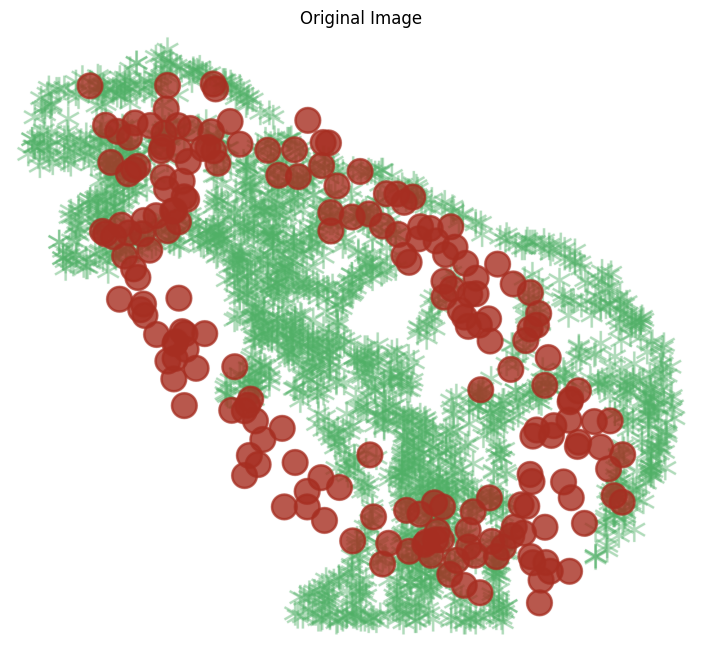

In [29]:

filename = '/content/red_green_overlay.png'
# Read the image
image = cv2.imread(filename)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_image = image_rgb.copy()

# Display the original image
plt.figure(figsize=(10, 8))
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.show()

In [30]:

def detect_crosses_with_border_analysis(image):
    """
    Detect light green crosses considering they might have borders
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Light green color ranges
    light_green_lower = np.array([35, 40, 40])
    light_green_upper = np.array([85, 255, 255])

    mask_green = cv2.inRange(hsv, light_green_lower, light_green_upper)

    # Morphological operations to clean the mask
    kernel = np.ones((3, 3), np.uint8)
    mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)
    mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_CLOSE, kernel)

    return mask_green

def detect_red_circles_with_dark_border(image):
    """
    Specialized detection for red circles with dark red borders
    """
    # Convert to different color spaces
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Method 1: Detect dark red borders in HSV
    dark_red_lower1 = np.array([0, 50, 20])    # Low value for dark red
    dark_red_upper1 = np.array([10, 255, 100])
    dark_red_lower2 = np.array([160, 50, 20])  # Low value for dark red
    dark_red_upper2 = np.array([180, 255, 100])

    dark_red_mask1 = cv2.inRange(hsv, dark_red_lower1, dark_red_upper1)
    dark_red_mask2 = cv2.inRange(hsv, dark_red_lower2, dark_red_upper2)
    dark_red_mask = cv2.bitwise_or(dark_red_mask1, dark_red_mask2)

    # Method 2: Detect bright red centers
    bright_red_lower1 = np.array([0, 50, 150])    # High value for bright red
    bright_red_upper1 = np.array([10, 255, 255])
    bright_red_lower2 = np.array([160, 50, 150])  # High value for bright red
    bright_red_upper2 = np.array([180, 255, 255])

    bright_red_mask1 = cv2.inRange(hsv, bright_red_lower1, bright_red_upper1)
    bright_red_mask2 = cv2.inRange(hsv, bright_red_lower2, bright_red_upper2)
    bright_red_mask = cv2.bitwise_or(bright_red_mask1, bright_red_mask2)

    # Method 3: Use LAB color space for better red separation
    a_channel = lab[:, :, 1]
    # Red areas typically have high values in A channel
    red_lab_mask = cv2.inRange(a_channel, 130, 255)

    # Combine all red detections
    combined_red = cv2.bitwise_or(dark_red_mask, bright_red_mask)
    combined_red = cv2.bitwise_or(combined_red, red_lab_mask)

    # Use circular Hough transform to find circles
    circles = cv2.HoughCircles(
        gray,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=20,
        param1=50,
        param2=30,
        minRadius=5,
        maxRadius=30
    )

    # Create mask from detected circles
    circle_mask = np.zeros_like(gray)
    circle_list = []

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        circle_list = circles.tolist()
        for (x, y, r) in circles:
            cv2.circle(circle_mask, (x, y), r, 255, -1)

    # Combine circle detection with color detection
    final_red_mask = cv2.bitwise_and(combined_red, circle_mask)

    # Also include areas that are circular based on morphology
    kernel_circle = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    circular_areas = cv2.morphologyEx(combined_red, cv2.MORPH_OPEN, kernel_circle)

    final_red_mask = cv2.bitwise_or(final_red_mask, circular_areas)

    # Clean up the mask
    kernel = np.ones((2, 2), np.uint8)
    final_red_mask = cv2.morphologyEx(final_red_mask, cv2.MORPH_OPEN, kernel)

    return final_red_mask, circle_list

def find_cross_centers_robust(mask_green):
    """Find centers of crosses"""
    contours, _ = cv2.findContours(mask_green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cross_centers = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 3:
            continue

        M = cv2.moments(contour)
        if M["m00"] != 0:
            center_x = int(M["m10"] / M["m00"])
            center_y = int(M["m01"] / M["m00"])
            cross_centers.append((center_x, center_y))

    return cross_centers

def find_red_circle_centers(mask_red, circle_list, original_image):
    """
    Find centers of red circles using multiple methods
    """
    red_centers = []

    # Method 1: Use contours from the red mask
    contours, _ = cv2.findContours(mask_red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        if 10 < area < 500:  # Reasonable size for points
            M = cv2.moments(contour)
            if M["m00"] != 0:
                center_x = int(M["m10"] / M["m00"])
                center_y = int(M["m01"] / M["m00"])

                # Verify this is actually red by checking the original image
                if is_red_point(original_image, center_x, center_y):
                    red_centers.append((center_x, center_y))

    # Method 2: Use Hough circles directly
    if circle_list:
        for circle in circle_list:
            x, y, r = circle
            # Verify this is actually red
            if is_red_point(original_image, x, y):
                red_centers.append((x, y))

    # Remove duplicates
    unique_centers = []
    for center in red_centers:
        is_duplicate = False
        for existing in unique_centers:
            distance = np.sqrt((center[0]-existing[0])**2 + (center[1]-existing[1])**2)
            if distance < 10:
                is_duplicate = True
                break
        if not is_duplicate:
            unique_centers.append(center)

    return unique_centers

def is_red_point(image, x, y, radius=10):
    """
    Verify if a point is actually red by checking surrounding area
    """
    h, w = image.shape[:2]

    # Define region of interest
    x1 = max(0, x - radius)
    x2 = min(w, x + radius)
    y1 = max(0, y - radius)
    y2 = min(h, y + radius)

    if x1 >= x2 or y1 >= y2:
        return False

    roi = image[y1:y2, x1:x2]

    if roi.size == 0:
        return False

    # Convert ROI to HSV
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_RGB2HSV)

    # Check for red colors (both ranges)
    red_mask1 = cv2.inRange(hsv_roi, np.array([0, 50, 50]), np.array([10, 255, 255]))
    red_mask2 = cv2.inRange(hsv_roi, np.array([160, 50, 50]), np.array([180, 255, 255]))
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    # If more than 20% of the area is red, consider it a red point
    red_ratio = np.sum(red_mask > 0) / (red_mask.size + 1e-6)

    return red_ratio > 0.2





In [31]:
def enhanced_green_cross_detection(image):
    """
    Enhanced detection for green crosses that handles overlapping and finds more crosses
    """
    # Convert to multiple color spaces for better detection
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Multiple green color ranges to capture variations
    green_ranges_hsv = [
        ([35, 30, 30], [85, 255, 255]),    # Standard light green
        ([30, 20, 20], [90, 255, 200]),    # Wider range
        ([40, 40, 40], [80, 255, 255]),    # More saturated
        ([25, 30, 30], [95, 255, 220]),    # Even wider range
    ]

    # LAB color space for green detection
    lab_ranges = [
        ([0, 120, 120], [255, 140, 140]),  # Green in LAB
    ]

    combined_green_mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # HSV-based detection
    for lower, upper in green_ranges_hsv:
        lower = np.array(lower)
        upper = np.array(upper)
        mask = cv2.inRange(hsv, lower, upper)
        combined_green_mask = cv2.bitwise_or(combined_green_mask, mask)

    # LAB-based detection
    for lower, upper in lab_ranges:
        lower = np.array(lower)
        upper = np.array(upper)
        mask = cv2.inRange(lab, lower, upper)
        combined_green_mask = cv2.bitwise_or(combined_green_mask, mask)

    # Use morphological operations to separate overlapping crosses
    kernel_cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))
    kernel_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

    # Step 1: Remove noise
    cleaned_mask = cv2.morphologyEx(combined_green_mask, cv2.MORPH_OPEN, kernel_ellipse)

    # Step 2: Separate connected components
    separated_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel_cross)

    # Step 3: Use watershed algorithm for overlapping crosses
    distance_map = cv2.distanceTransform(cleaned_mask, cv2.DIST_L2, 5)
    _, sure_foreground = cv2.threshold(distance_map, 0.3 * distance_map.max(), 255, 0)
    sure_foreground = np.uint8(sure_foreground)

    # Combine methods
    final_mask = cv2.bitwise_or(separated_mask, sure_foreground)

    # Final cleaning
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel_ellipse)

    return final_mask, cleaned_mask, separated_mask

def detect_cross_centers_advanced(mask, original_image, min_area_ratio=0.00005, max_area_ratio=0.005):
    """
    Advanced cross center detection with shape analysis and overlapping handling
    """
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cross_centers = []
    cross_properties = []

    img_area = original_image.shape[0] * original_image.shape[1]
    min_area = img_area * min_area_ratio
    max_area = img_area * max_area_ratio

    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)

        # Area filtering
        if area < min_area or area > max_area:
            continue

        # Basic shape properties
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = max(w, h) / min(w, h) if min(w, h) > 0 else 0

        # Calculate shape properties for cross detection
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        solidity = area / hull_area if hull_area > 0 else 0

        perimeter = cv2.arcLength(contour, True)
        circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0

        # Cross-specific features
        # 1. Crosses have lower solidity (due to arms)
        # 2. Moderate aspect ratio (not too elongated)
        # 3. Lower circularity (not round)

        cross_likelihood = 0

        # Solidty check (crosses have lower solidity)
        if 0.2 <= solidity <= 0.7:
            cross_likelihood += 1

        # Aspect ratio check
        if 0.8 <= aspect_ratio <= 2.5:
            cross_likelihood += 1

        # Circularity check (crosses are less circular)
        if circularity < 0.6:
            cross_likelihood += 1

        # If it meets cross criteria, or use more lenient approach
        if cross_likelihood >= 2:
            # Calculate center using moments
            M = cv2.moments(contour)
            if M["m00"] != 0:
                center_x = int(M["m10"] / M["m00"])
                center_y = int(M["m01"] / M["m00"])

                cross_centers.append((center_x, center_y))
                cross_properties.append({
                    'area': area,
                    'solidity': solidity,
                    'aspect_ratio': aspect_ratio,
                    'circularity': circularity,
                    'cross_likelihood': cross_likelihood
                })

    return cross_centers, cross_properties

def find_additional_crosses_using_template_matching(image, existing_centers):
    """
    Use template matching to find additional crosses that might be missed
    """
    # Convert to grayscale for template matching
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Create a simple cross template
    template_size = 15
    template = np.zeros((template_size, template_size), dtype=np.uint8)
    center = template_size // 2

    # Draw a simple cross
    cv2.line(template, (center, 0), (center, template_size-1), 255, 2)
    cv2.line(template, (0, center), (template_size-1, center), 255, 2)

    # Perform template matching
    result = cv2.matchTemplate(gray, template, cv2.TM_CCOEFF_NORMED)

    # Find matches above threshold
    threshold = 0.4
    locations = np.where(result >= threshold)

    additional_centers = []
    for pt in zip(*locations[::-1]):  # Switch x and y
        center_x = pt[0] + center
        center_y = pt[1] + center

        # Check if this center is too close to existing ones
        too_close = False
        for existing_center in existing_centers:
            distance = np.sqrt((center_x - existing_center[0])**2 + (center_y - existing_center[1])**2)
            if distance < 20:  # Minimum distance between crosses
                too_close = True
                break

        if not too_close:
            additional_centers.append((center_x, center_y))

    return additional_centers

def detect_red_points_simple(image):
    """
    Simple red point detection for comparison
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Red color ranges
    red1_lower = np.array([0, 40, 40])
    red1_upper = np.array([15, 255, 255])
    red2_lower = np.array([160, 40, 40])
    red2_upper = np.array([180, 255, 255])

    mask1 = cv2.inRange(hsv, red1_lower, red1_upper)
    mask2 = cv2.inRange(hsv, red2_lower, red2_upper)
    red_mask = cv2.bitwise_or(mask1, mask2)

    # Clean up
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)

    # Find centers
    contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    red_centers = []

    for contour in contours:
        area = cv2.contourArea(contour)
        if 5 < area < 200:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                center_x = int(M["m10"] / M["m00"])
                center_y = int(M["m01"] / M["m00"])
                red_centers.append((center_x, center_y))

    return red_centers, red_mask

# Run enhanced cross detection
print("Running enhanced green cross detection...")

# Detect green crosses with enhanced method
final_green_mask, cleaned_mask, separated_mask = enhanced_green_cross_detection(original_image)
cross_centers, cross_props = detect_cross_centers_advanced(final_green_mask, original_image)

# Find additional crosses using template matching
additional_crosses = find_additional_crosses_using_template_matching(original_image, cross_centers)

# Combine all crosses
all_cross_centers = cross_centers + additional_crosses

# Remove duplicates
unique_cross_centers = []
for center in all_cross_centers:
    is_duplicate = False
    for existing in unique_cross_centers:
        distance = np.sqrt((center[0]-existing[0])**2 + (center[1]-existing[1])**2)
        if distance < 15:
            is_duplicate = True
            break
    if not is_duplicate:
        unique_cross_centers.append(center)

# Detect red points
red_centers, red_mask = detect_red_points_simple(original_image)



# Detect red circles with dark borders
red_mask, circle_list = detect_red_circles_with_dark_border(original_image)
red_centers = find_red_circle_centers(red_mask, circle_list, original_image)




print(f"Enhanced detection results:")
print(f"Found {len(unique_cross_centers)} green crosses (initial: {len(cross_centers)}, additional: {len(additional_crosses)})")
print(f"Found {len(red_centers)} red points")



Running enhanced green cross detection...
Enhanced detection results:
Found 1445 green crosses (initial: 0, additional: 12457)
Found 227 red points


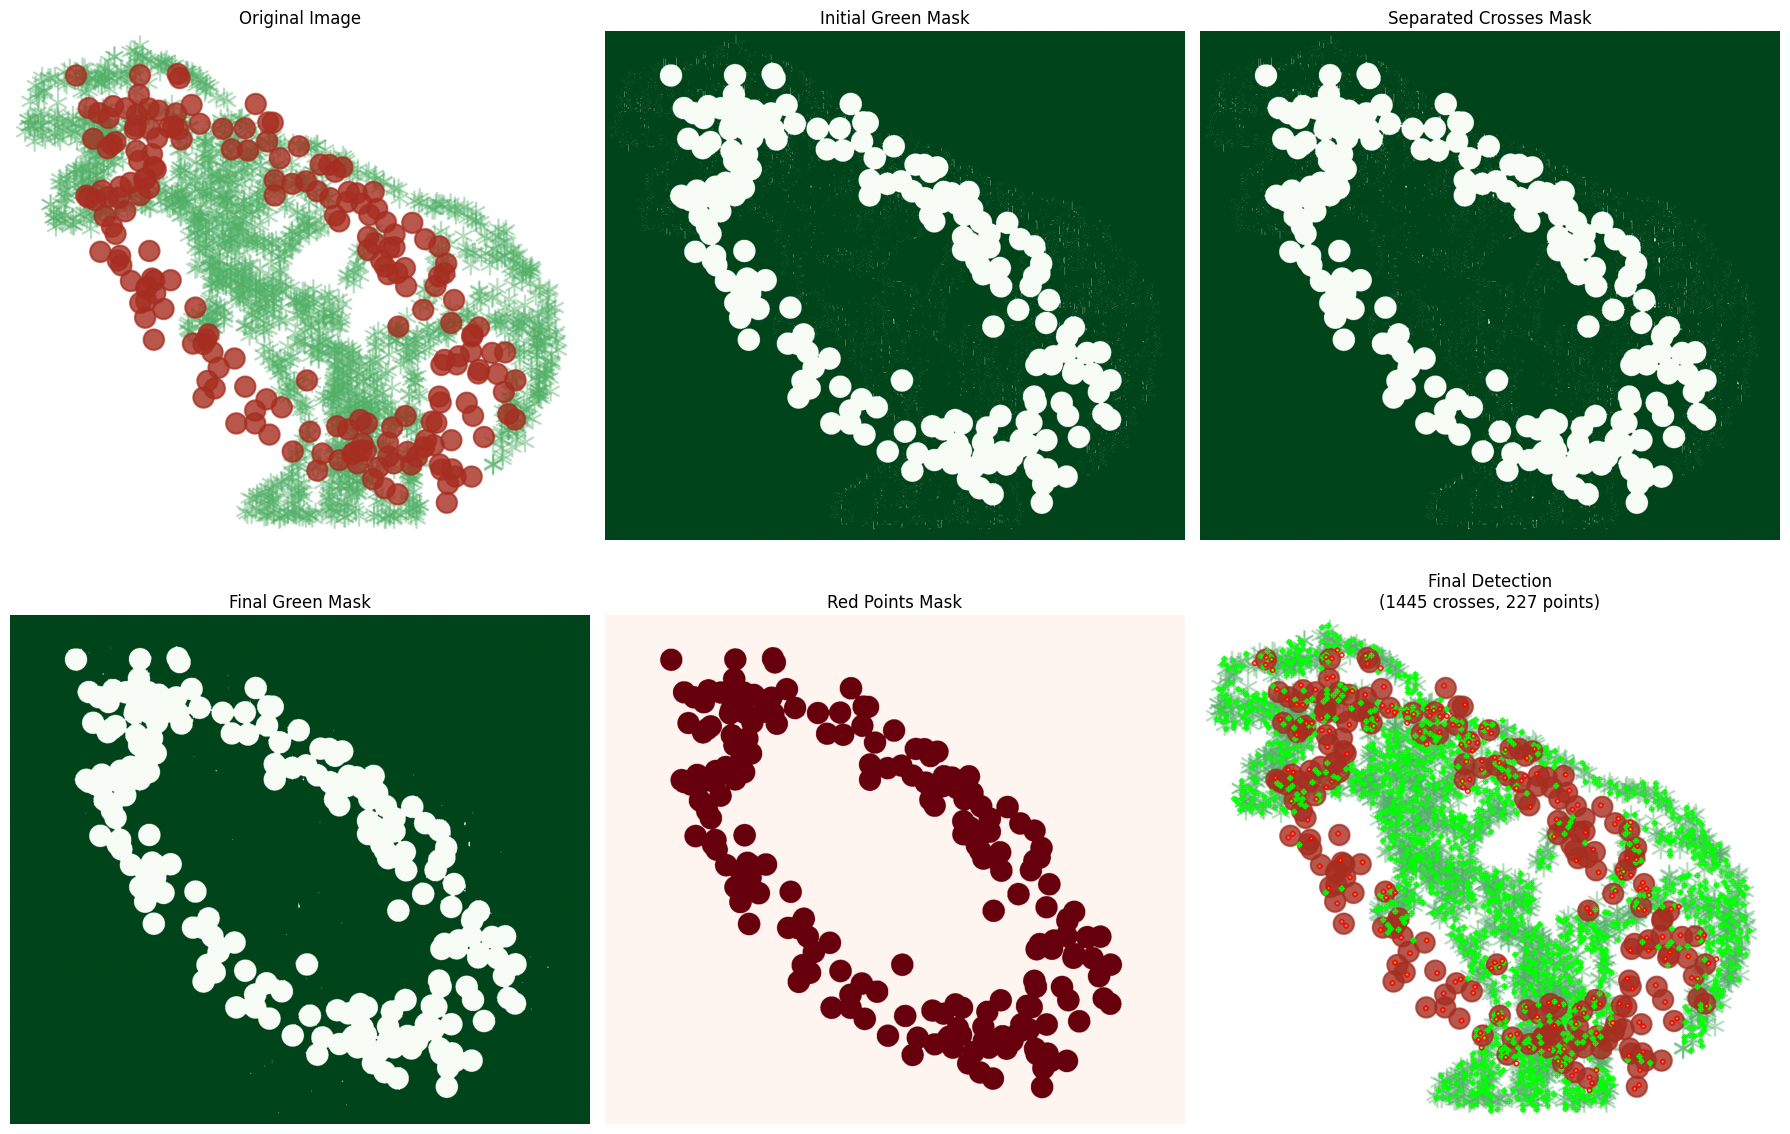

In [13]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Original image
axes[0, 0].imshow(original_image)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# Cleaned green mask
axes[0, 1].imshow(cleaned_mask, cmap='Greens')
axes[0, 1].set_title('Initial Green Mask')
axes[0, 1].axis('off')

# Separated mask
axes[0, 2].imshow(separated_mask, cmap='Greens')
axes[0, 2].set_title('Separated Crosses Mask')
axes[0, 2].axis('off')

# Final green mask
axes[1, 0].imshow(final_green_mask, cmap='Greens')
axes[1, 0].set_title('Final Green Mask')
axes[1, 0].axis('off')

# Red mask
axes[1, 1].imshow(red_mask, cmap='Reds')
axes[1, 1].set_title('Red Points Mask')
axes[1, 1].axis('off')


# Final result
result_image = original_image.copy()
for center in unique_cross_centers:
    cv2.drawMarker(result_image, center, (0, 255, 0), cv2.MARKER_CROSS, 20, 3)
    cv2.circle(result_image, center, 8, (0, 255, 0), 2)

for center in red_centers:
    cv2.circle(result_image, center, 8, (255, 0, 0), 3)
    cv2.circle(result_image, center, 2, (255, 255, 0), -1)

axes[1, 2].imshow(result_image)
axes[1, 2].set_title(f'Final Detection\n({len(unique_cross_centers)} crosses, {len(red_centers)} points)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

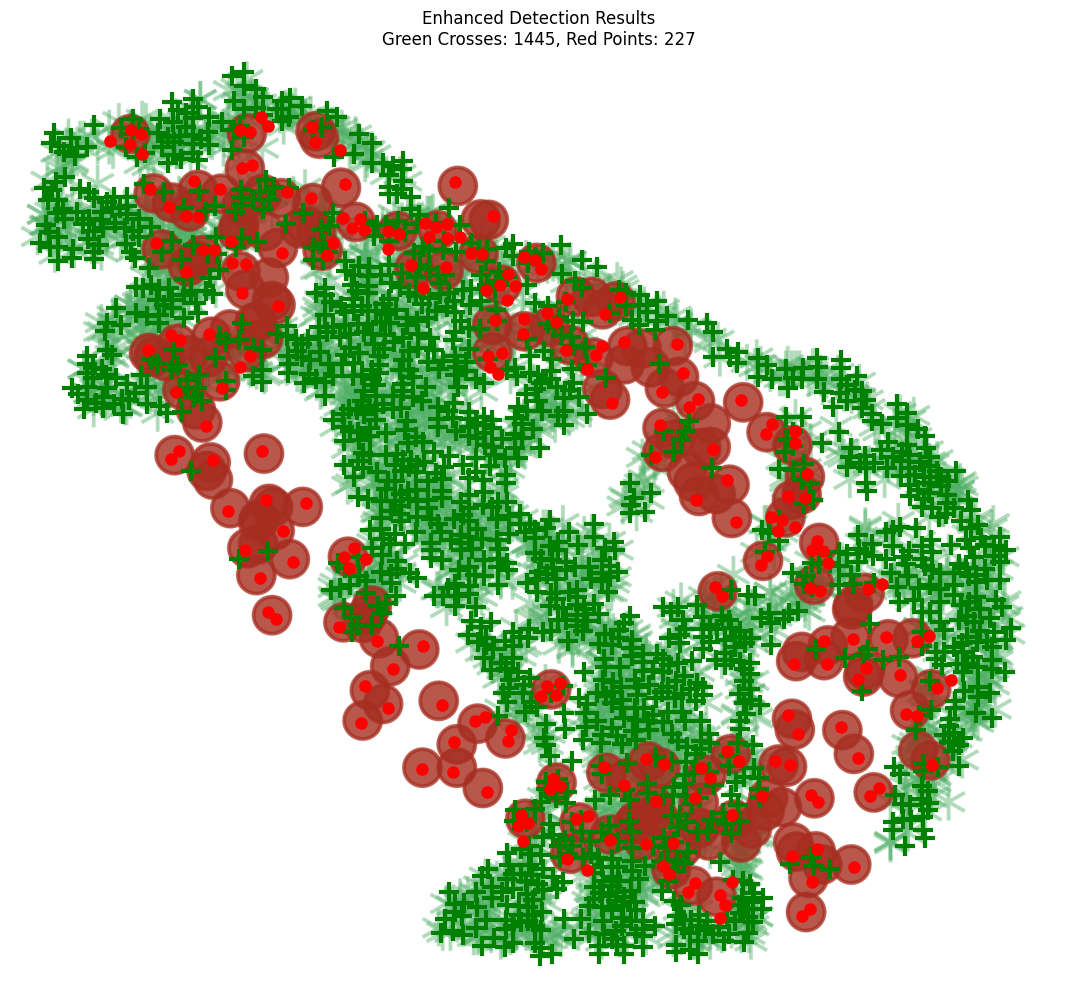

In [14]:
# Create detailed result visualization
plt.figure(figsize=(15, 10))
plt.imshow(original_image)

# Plot crosses with numbers
for i, center in enumerate(unique_cross_centers):
    plt.plot(center[0], center[1], 'g+', markersize=15, markeredgewidth=3)
    #plt.text(center[0] + 15, center[1], f'C{i+1}', fontsize=8, color='green',
    #         bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

# Plot red points with numbers
for i, center in enumerate(red_centers):
    plt.plot(center[0], center[1], 'ro', markersize=8)
    #plt.text(center[0] + 15, center[1], f'P{i+1}', fontsize=8, color='red',
    #         bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

plt.title(f'Enhanced Detection Results\nGreen Crosses: {len(unique_cross_centers)}, Red Points: {len(red_centers)}')
plt.axis('off')
plt.tight_layout()
plt.show()



In [11]:
# Create DataFrame
data = []

# Add crosses to DataFrame
for center in unique_cross_centers:
    x, y = center
    data.append({'X': x, 'Y': y, 'Color': 'light_green', 'Type': 'cross'})

# Add red points to DataFrame
for center in red_centers:
    x, y = center
    data.append({'X': x, 'Y': y, 'Color': 'red', 'Type': 'point'})

df = pd.DataFrame(data)

print("\nEnhanced DataFrame:")
print(df.head(20))
print(f"\nTotal objects: {len(df)}")
print(f"Crosses: {len(unique_cross_centers)}")
print(f"Points: {len(red_centers)}")

# Save results
df.to_csv('enhanced_cross_detection.csv', index=False)

print("\nResults saved to 'enhanced_cross_detection.csv'")

# Display cross properties if available
if cross_props:
    print("\nCross Properties Analysis:")
    props_df = pd.DataFrame(cross_props)
    print(props_df.describe())


Enhanced DataFrame:
      X    Y        Color   Type
0   453   37  light_green  cross
1   430   44  light_green  cross
2   452   64  light_green  cross
3   476   69  light_green  cross
4   490   84  light_green  cross
5   542   87  light_green  cross
6   354   89  light_green  cross
7   434   92  light_green  cross
8   527   92  light_green  cross
9   314   95  light_green  cross
10  566  102  light_green  cross
11  363  104  light_green  cross
12  476  106  light_green  cross
13  452  108  light_green  cross
14  517  108  light_green  cross
15  325  109  light_green  cross
16  614  112  light_green  cross
17  340  116  light_green  cross
18  490  120  light_green  cross
19  540  123  light_green  cross

Total objects: 1672
Crosses: 1445
Points: 227

Results saved to 'enhanced_cross_detection.csv'
